In [10]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pickle as pkl
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, Conv2DTranspose, Reshape, Input
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

In [11]:
# Dataset directories
train_data_dir = "Dataset/Preprocessed/Tomato/train_set"
test_data_dir = "Dataset/Preprocessed/Tomato/test_set"

In [12]:
# Get the first image from the healthy directory
first_image_file = os.listdir(f"{train_data_dir}/healthy")[0]
img = plt.imread(f"{train_data_dir}/healthy/{first_image_file}")

img_height, img_width, _ = img.shape

print(f"Image size: {img_height}x{img_width}")

Image size: 400x400


In [13]:
# Set batch size
img_width, img_height = 400, 400
batch_size = 16

In [14]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(train_data_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode="categorical", shuffle=True, seed=42)
test_generator = test_datagen.flow_from_directory(test_data_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode="categorical", shuffle=True, seed=42)

Found 21723 images belonging to 5 classes.
Found 5445 images belonging to 5 classes.


In [15]:
# Number of classes
num_classes = len(train_generator.class_indices)
print(f"Number of classes: {num_classes}")

Number of classes: 5


In [16]:
# Set number of epochs
epochs_number = 20

#### Testing pretrained ResNet-50 model


In [17]:
# Load the ResNet50 model
base_resNet_model = ResNet50V2(weights="imagenet", include_top=False, input_shape=(img_height, img_width, 3))

# Add custom classification head
x = base_resNet_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.3)(x)
predictions = Dense(num_classes, activation="softmax")(x)

# Create model
resnet_model = Model(inputs=base_resNet_model.input, outputs=predictions)

# Freeze convolutional layers
for layer in base_resNet_model.layers:
    layer.trainable = False

# Compile model
optimizer = Adam(learning_rate=0.001)
resnet_model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [18]:
# Train model
resNet_history = resnet_model.fit(train_generator, steps_per_epoch=train_generator.samples // batch_size, epochs=epochs_number, validation_data=test_generator, validation_steps=test_generator.samples // batch_size)

Epoch 1/20
1357/1357 [==============================] - 104s 75ms/step - loss: 1.0768 - accuracy: 0.5800 - val_loss: 0.8300 - val_accuracy: 0.6535
Epoch 2/20
1357/1357 [==============================] - 98s 72ms/step - loss: 0.8606 - accuracy: 0.6539 - val_loss: 0.7904 - val_accuracy: 0.7026
Epoch 3/20
1357/1357 [==============================] - 96s 71ms/step - loss: 0.7778 - accuracy: 0.6907 - val_loss: 0.5960 - val_accuracy: 0.7779
Epoch 4/20
1357/1357 [==============================] - 96s 71ms/step - loss: 0.7062 - accuracy: 0.7183 - val_loss: 0.5312 - val_accuracy: 0.7967
Epoch 5/20
1357/1357 [==============================] - 96s 71ms/step - loss: 0.6446 - accuracy: 0.7481 - val_loss: 0.5082 - val_accuracy: 0.8090
Epoch 6/20
1357/1357 [==============================] - 96s 71ms/step - loss: 0.5888 - accuracy: 0.7707 - val_loss: 0.4350 - val_accuracy: 0.8382
Epoch 7/20
1357/1357 [==============================] - 97s 71ms/step - loss: 0.5314 - accuracy: 0.7946 - val_loss: 0.3635 

In [19]:
# Save trained model
resnet_model.save("resNet_model.h5")

c:\ProgramData\anaconda3\envs\base_3_9\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


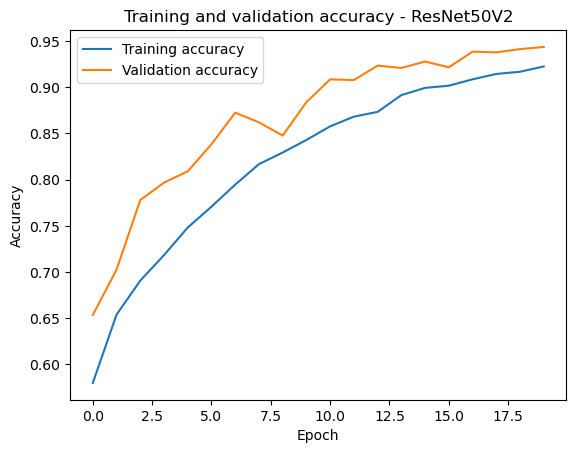

In [20]:
# Plot training and validation accuracy
plt.plot(resNet_history.history["accuracy"], label="Training accuracy")
plt.plot(resNet_history.history["val_accuracy"], label="Validation accuracy")
plt.title("Training and validation accuracy - ResNet50V2")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

#### Testing DenseNet-121 model


In [21]:
# Load pre-trained DenseNet121 model
base_denseNet_model = DenseNet121(weights="imagenet", include_top=False, input_shape=(img_height, img_width, 3))

# Add custom classification head
x = base_denseNet_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.3)(x)
predictions = Dense(num_classes, activation="softmax")(x)

# Create model
denseNet_model = Model(inputs=base_denseNet_model.input, outputs=predictions)

# Freeze convolutional layers
for layer in base_denseNet_model.layers:
    layer.trainable = False

# Compile model
optimizer = Adam(learning_rate=0.001)
denseNet_model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [22]:
# Train model
denseNet_history = denseNet_model.fit(train_generator, steps_per_epoch=train_generator.samples // batch_size, epochs=epochs_number, validation_data=test_generator, validation_steps=test_generator.samples // batch_size)

Epoch 1/20
1357/1357 [==============================] - 125s 87ms/step - loss: 1.0160 - accuracy: 0.6015 - val_loss: 0.7888 - val_accuracy: 0.7017
Epoch 2/20
1357/1357 [==============================] - 115s 85ms/step - loss: 0.8251 - accuracy: 0.6736 - val_loss: 0.7360 - val_accuracy: 0.7138
Epoch 3/20
1357/1357 [==============================] - 116s 85ms/step - loss: 0.7472 - accuracy: 0.7004 - val_loss: 0.6905 - val_accuracy: 0.7274
Epoch 4/20
1357/1357 [==============================] - 115s 85ms/step - loss: 0.6987 - accuracy: 0.7229 - val_loss: 0.5520 - val_accuracy: 0.7822
Epoch 5/20
1357/1357 [==============================] - 116s 85ms/step - loss: 0.6429 - accuracy: 0.7479 - val_loss: 0.5207 - val_accuracy: 0.8029
Epoch 6/20
1357/1357 [==============================] - 116s 86ms/step - loss: 0.6028 - accuracy: 0.7644 - val_loss: 0.4395 - val_accuracy: 0.8296
Epoch 7/20
1357/1357 [==============================] - 115s 85ms/step - loss: 0.5636 - accuracy: 0.7806 - val_loss: 0

In [23]:
# Save trained model
denseNet_model.save("denseNet_model.h5")

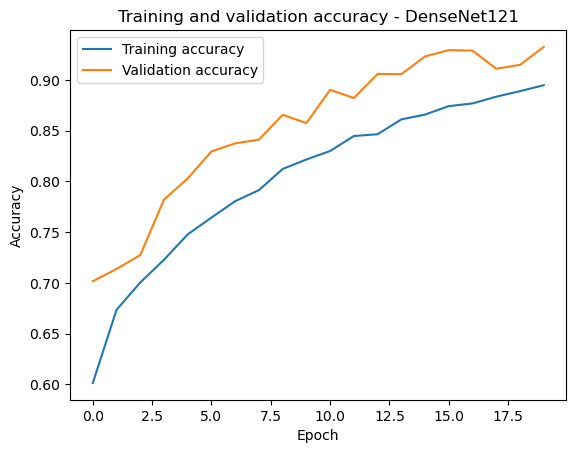

In [24]:
plt.plot(denseNet_history.history["accuracy"], label="Training accuracy")
plt.plot(denseNet_history.history["val_accuracy"], label="Validation accuracy")
plt.title("Training and validation accuracy - DenseNet121")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

#### Testing custom CNN model


In [25]:
# Custom CNN architecture
custom_model = Sequential(
    [
        Conv2D(32, (3, 3), activation="relu", input_shape=(img_height, img_width, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation="relu"),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation="relu"),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation="relu"),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation="relu"),
        Dropout(0.5),
        Dense(num_classes, activation="softmax"),
    ]
)

# Compile the model
optimizer = Adam(learning_rate=0.001)
custom_model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [26]:
# Train the model
custom_CNN_history = custom_model.fit(train_generator, steps_per_epoch=train_generator.samples // batch_size, epochs=epochs_number, validation_data=test_generator, validation_steps=test_generator.samples // batch_size)

Epoch 1/20
1357/1357 [==============================] - 67s 48ms/step - loss: 1.2670 - accuracy: 0.4604 - val_loss: 1.0349 - val_accuracy: 0.5592
Epoch 2/20
1357/1357 [==============================] - 65s 48ms/step - loss: 1.0459 - accuracy: 0.5571 - val_loss: 0.8789 - val_accuracy: 0.6441
Epoch 3/20
1357/1357 [==============================] - 65s 48ms/step - loss: 0.8591 - accuracy: 0.6549 - val_loss: 0.6819 - val_accuracy: 0.7458
Epoch 4/20
1357/1357 [==============================] - 65s 48ms/step - loss: 0.6181 - accuracy: 0.7634 - val_loss: 0.5046 - val_accuracy: 0.8369
Epoch 5/20
1357/1357 [==============================] - 65s 48ms/step - loss: 0.4134 - accuracy: 0.8467 - val_loss: 0.4773 - val_accuracy: 0.8555
Epoch 6/20
1357/1357 [==============================] - 64s 47ms/step - loss: 0.2792 - accuracy: 0.9004 - val_loss: 0.4605 - val_accuracy: 0.8869
Epoch 7/20
1357/1357 [==============================] - 65s 48ms/step - loss: 0.2026 - accuracy: 0.9299 - val_loss: 0.4932 -

In [27]:
# Save the trained model
custom_model.save("custom_CNN_model.h5")

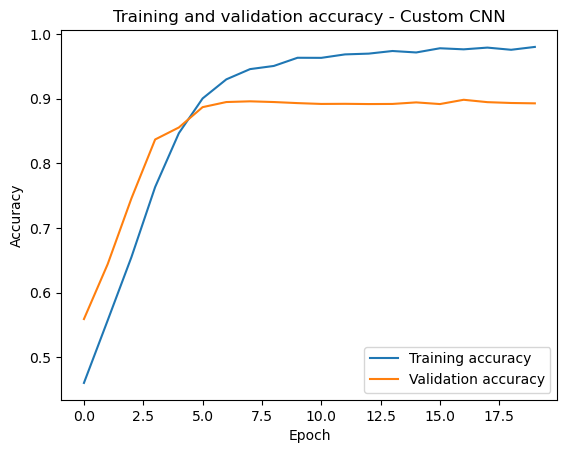

In [28]:
plt.plot(custom_CNN_history.history["accuracy"], label="Training accuracy")
plt.plot(custom_CNN_history.history["val_accuracy"], label="Validation accuracy")
plt.title("Training and validation accuracy - Custom CNN")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

#### Evaluate models

In [29]:
# Table comparing the performance of the three models
resNet_accuracy = resNet_history.history["accuracy"][-1]
resNet_val_accuracy = resNet_history.history["val_accuracy"][-1]
denseNet_accuracy = denseNet_history.history["accuracy"][-1]
denseNet_val_accuracy = denseNet_history.history["val_accuracy"][-1]
custom_CNN_accuracy = custom_CNN_history.history["accuracy"][-1]
custom_CNN_val_accuracy = custom_CNN_history.history["val_accuracy"][-1]

model_comparison = pd.DataFrame(
    {
        "Model": ["ResNet50V2", "DenseNet121", "Custom CNN"],
        "Train Accuracy": [resNet_accuracy, denseNet_accuracy, custom_CNN_accuracy],
        "Validation Accuracy": [resNet_val_accuracy, denseNet_val_accuracy, custom_CNN_val_accuracy],
    }
)

print(model_comparison)

         Model  Train Accuracy  Validation Accuracy
0   ResNet50V2        0.922421             0.943566
1  DenseNet121        0.894780             0.932537
2   Custom CNN        0.980099             0.892831


#### Testing custom GAN model


In [30]:
# # Generator
# def build_generator(latent_dim):
#     input_noise = Input(shape=(latent_dim,))
#     x = Dense(7 * 7 * 128, activation="relu")(input_noise)
#     x = Reshape((7, 7, 128))(x)
#     x = Conv2DTranspose(128, kernel_size=3, strides=2, padding="same", activation="relu")(x)
#     x = Conv2DTranspose(64, kernel_size=3, strides=2, padding="same", activation="relu")(x)
#     output_img = Conv2D(3, kernel_size=3, padding="same", activation="tanh")(x)
#     generator = Model(input_noise, output_img)
#     return generator

# latent_dim = 100
# generator = build_generator(latent_dim)


# # Discriminator
# def build_discriminator(input_shape):
#     input_img = Input(shape=input_shape)
#     x = Conv2D(64, kernel_size=3, strides=2, padding="same", activation="relu")(input_img)
#     x = Conv2D(128, kernel_size=3, strides=2, padding="same", activation="relu")(x)
#     x = Flatten()(x)
#     output = Dense(1, activation="sigmoid")(x)
#     discriminator = Model(input_img, output)
#     discriminator.compile(optimizer=Adam(learning_rate=0.0002), loss="binary_crossentropy", metrics=["accuracy"])
#     return discriminator

# input_shape = (img_height, img_width, 3)  # Assuming 3 channels for RGB images
# discriminator = build_discriminator(input_shape)


# # Combined GAN model
# discriminator.trainable = False
# gan_input = Input(shape=(latent_dim,))
# gan_output = discriminator(generator(gan_input))
# gan = Model(gan_input, gan_output)
# gan.compile(optimizer=Adam(learning_rate=0.0002), loss="binary_crossentropy")

In [31]:
# # Training GAN
# def train_gan(generator, discriminator, gan, train_generator, test_generator, latent_dim, epochs, batch_size):
#     num_batches = len(train_generator)
#     for epoch in range(epochs):
#         for batch in range(num_batches):
#             real_images, labels = next(train_generator)

#             noise = np.random.normal(0, 1, (batch_size, latent_dim))
#             fake_images = generator.predict(noise)

#             discriminator_loss_real = discriminator.train_on_batch(real_images, np.ones((batch_size, 1)))
#             discriminator_loss_fake = discriminator.train_on_batch(fake_images, np.zeros((batch_size, 1)))
#             discriminator_loss = 0.5 * np.add(discriminator_loss_real, discriminator_loss_fake)

#             noise = np.random.normal(0, 1, (batch_size, latent_dim))
#             gan_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

#             if batch % 100 == 0:
#                 print(f"Epoch: {epoch}, Batch: {batch}/{num_batches}, Discriminator Loss: {discriminator_loss}, GAN Loss: {gan_loss}")

#     # Evaluate GAN performance on test set
#     test_loss, test_accuracy = gan.evaluate(test_generator)
#     print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# train_gan(generator, discriminator, gan, train_generator, test_generator, latent_dim, epochs=20, batch_size=batch_size)

In [32]:
# # Save the trained generator model
# generator.save("gan_model.h5")